# 1. Build your own convolutional neural network using pytorch

In [ ]:
# # unzip train test set
# !unzip /content/Dog_heart.zip
# !unzip /content/Test.zip

Archive:  /content/Dog_heart.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/Dog_heart.zip or
        /content/Dog_heart.zip.zip, and cannot find /content/Dog_heart.zip.ZIP, period.
Archive:  /content/Test.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/Test.zip or
        /content/Test.zip.zip, and cannot find /content/Test.zip.ZIP, period.


In [ ]:
!unzip /content/Dog_heart.zip -d /content/
!unzip /content/Test.zip -d /content/

Archive:  /content/Dog_heart.zip
   creating: /content/Dog_heart/
   creating: /content/Dog_heart/Train/
   creating: /content/Dog_heart/Train/Large/
  inflating: /content/Dog_heart/Train/Large/1001.png  
  inflating: /content/Dog_heart/Train/Large/1004.png  
  inflating: /content/Dog_heart/Train/Large/1005.png  
  inflating: /content/Dog_heart/Train/Large/1008.png  
  inflating: /content/Dog_heart/Train/Large/101.png  
  inflating: /content/Dog_heart/Train/Large/1011.png  
 extracting: /content/Dog_heart/Train/Large/1015.png  
  inflating: /content/Dog_heart/Train/Large/1018.png  
  inflating: /content/Dog_heart/Train/Large/1019.png  
  inflating: /content/Dog_heart/Train/Large/1021.png  
  inflating: /content/Dog_heart/Train/Large/1025.png  
  inflating: /content/Dog_heart/Train/Large/1030.png  
  inflating: /content/Dog_heart/Train/Large/1032.png  
  inflating: /content/Dog_heart/Train/Large/1035.png  
  inflating: /content/Dog_heart/Train/Large/1036.png  
  inflating: /content/Dog_

In [ ]:
!unzip /content/Dog_heart.zip -d /content/


Archive:  /content/Dog_heart.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/Dog_heart.zip or
        /content/Dog_heart.zip.zip, and cannot find /content/Dog_heart.zip.ZIP, period.


Load best model from last model run

In [ ]:
# save model in google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to the .pth file in Google Drive
drive_path = '/content/drive/My Drive/YU Katz AI/Fall 24/Deep Learning/Project 1/72%_best_model.pth'

# Path to the destination in Colab
colab_path = '/content/72%_best_model.pth'

!cp "/content/drive/My Drive/YU Katz AI/Fall 24/Deep Learning/Project 1/72%_best_model.pth" /content/
print("File successfully copied!")

File successfully copied!


Seed, imports, model

In [ ]:
import torch
import numpy as np
import random

def set_seed(seed=42):
    random.seed(seed)  # Python's random module
    np.random.seed(seed)  # Numpy
    torch.manual_seed(seed)  # PyTorch
    torch.cuda.manual_seed(seed)  # For CUDA (GPU)
    torch.cuda.manual_seed_all(seed)  # If using multi-GPU
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False  # Avoid benchmarking for determinism


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from PIL import Image
import os
import pandas as pd

In [ ]:
# residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class DogHeartCNN(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(DogHeartCNN, self).__init__()
        self.features = nn.Sequential(
            # First block
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            ResidualBlock(64, 64),

            # Second block * 4: 64, 128, 256, 512, 1024, then attention layer, and then 4 fully connected layers. Cosine scheduler, AdamW weight decay 0.01
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            ResidualBlock(128, 128),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            ResidualBlock(256, 256),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            ResidualBlock(512, 512),

            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            ResidualBlock(1024, 1024),

            nn.Dropout2d(0.2)
        )

        # Additional fully connected layers after features
        self.fc_layers = nn.Sequential(
            nn.Linear(1024 * 7 * 7, 4096),  # New fully connected layer
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, 2048),  # New fully connected layer
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),  # Increased from 256
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 3)  # Output layer
        )

    def forward(self, x):
        x = self.features(x)  # Feature extraction
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)  # Additional fully connected layers
        x = self.classifier(x)  # Classifier
        return x


# 2. Train your model using dog heart dataset (you may need to use  Google Colab (or Kaggle) with GPU to train your code)

### (1) use torchvision.datasets.ImageFolder for the training dataset
### (2) use custom dataloader for test dataset (return image tensor and file name)

In [ ]:
# Paths
train_path = '/content/Dog_heart/Train'
valid_path = '/content/Dog_heart/Valid'
test_path = '/content/Test'

In [ ]:
# prompt: count number of files in each directory/subdirectory of train_path, valid_path, test_path

import os

def count_files(path):
    counts = {}
    for root, dirs, files in os.walk(path):
        counts[root] = len(files)
    return counts

train_counts = count_files(train_path)
valid_counts = count_files(valid_path)
test_counts = count_files(test_path)

print("Train counts:", train_counts)
print("Valid counts:", valid_counts)
print("Test counts:", test_counts)

Train counts: {'/content/Dog_heart/Train': 0, '/content/Dog_heart/Train/Normal': 573, '/content/Dog_heart/Train/Large': 619, '/content/Dog_heart/Train/Small': 208}
Valid counts: {'/content/Dog_heart/Valid': 0, '/content/Dog_heart/Valid/Normal': 91, '/content/Dog_heart/Valid/Large': 76, '/content/Dog_heart/Valid/Small': 33}
Test counts: {'/content/Test': 400}


In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_valid_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# batch_size = 16
batch_size = 8

In [ ]:
# 2. Dataset and DataLoader

# Test Dataset Custom Loader
class TestDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = [f for f in os.listdir(root) if f.endswith(('jpg', 'png', 'jpeg'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.images[idx]

# Training and Validation datasets
train_dataset = datasets.ImageFolder(root=train_path, transform=transform_train)
valid_dataset = datasets.ImageFolder(root=valid_path, transform=transform_valid_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TestDataset(root=test_path, transform=transform_valid_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# lr = 0.00005
lr = 1e-5

In [ ]:
# 3. Model, Loss, and Optimizer
model = DogHeartCNN().to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

from torch.optim.lr_scheduler import StepLR

# Optimizer and Scheduler
# optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-6)  # Added weight decay
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)  # Added weight decay
# scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce LR every 5 epochs
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)  # T_max is the max number of epochs

Load best model so far to be further trained:

In [ ]:
#eval on best model
checkpoint = torch.load("72%_best_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
best_valid_accuracy = checkpoint['valid_accuracy']
print(f"Best model val accuracy: {best_valid_accuracy:.2f}%")

<ipython-input-18-b9f1639c116c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("72%_best_model.pth")


Best model val accuracy: 73.00%


Train

In [ ]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

# 4. Training the Model with Model Checkpoints and Plot Saving
def train_model(model, train_loader, valid_loader, num_epochs=10, save_path="best_model.pth"):
    best_valid_accuracy = 0  # Track the best validation accuracy

    # Lists to store metrics for plotting
    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")

        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        train_bar = tqdm(train_loader, desc="Training", leave=False)
        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update train progress bar
            train_accuracy = 100 * correct / total
            train_bar.set_postfix(loss=loss.item(), accuracy=train_accuracy)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)

        # Validation phase
        model.eval()
        valid_loss = 0
        correct = 0
        total = 0

        valid_bar = tqdm(valid_loader, desc="Validation", leave=False)
        with torch.no_grad():
            for images, labels in valid_bar:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Update validation progress bar
                valid_accuracy = 100 * correct / total
                valid_bar.set_postfix(loss=loss.item(), accuracy=valid_accuracy)

        valid_losses.append(valid_loss / len(valid_loader))
        valid_accuracies.append(100 * correct / total)

        # Print epoch summary
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, "
              f"Train Accuracy: {train_accuracies[-1]:.2f}%, Valid Loss: {valid_losses[-1]:.4f}, "
              f"Valid Accuracy: {valid_accuracies[-1]:.2f}%")

        # Save the model if validation accuracy improves
        if valid_accuracies[-1] > best_valid_accuracy and epoch >= 5:
            best_valid_accuracy = valid_accuracies[-1]
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'valid_accuracy': valid_accuracies[-1]
            }, save_path)
            print(f"Best model saved with accuracy: {best_valid_accuracy:.2f}%")

        # Scheduler step
        scheduler.step()
    return [train_losses, train_accuracies, valid_losses, valid_accuracies]
    # # Save the plot of metrics
    # plot_metrics(train_losses, train_accuracies, valid_losses, valid_accuracies)


In [ ]:
num_epochs = 20

In [ ]:
train_model(model, train_loader, valid_loader, num_epochs=num_epochs)

Epoch [1/20]


Epoch [1/20], Train Loss: 0.5310, Train Accuracy: 74.50%, Valid Loss: 0.6367, Valid Accuracy: 71.00%
Epoch [2/20]


Epoch [2/20], Train Loss: 0.5186, Train Accuracy: 76.57%, Valid Loss: 0.6197, Valid Accuracy: 71.50%
Epoch [3/20]


Epoch [3/20], Train Loss: 0.4893, Train Accuracy: 77.43%, Valid Loss: 0.6394, Valid Accuracy: 72.00%
Epoch [4/20]


Epoch [4/20], Train Loss: 0.4541, Train Accuracy: 79.57%, Valid Loss: 0.6691, Valid Accuracy: 71.50%
Epoch [5/20]


Epoch [5/20], Train Loss: 0.4627, Train Accuracy: 78.86%, Valid Loss: 0.6917, Valid Accuracy: 70.50%
Epoch [6/20]


Epoch [6/20], Train Loss: 0.4060, Train Accuracy: 82.57%, Valid Loss: 0.6370, Valid Accuracy: 70.50%
Best model saved with accuracy: 70.50%
Epoch [7/20]


Epoch [7/20], Train Loss: 0.3952, Train Accuracy: 83.21%, Valid Loss: 0.7197, Valid Accuracy: 69.00%
Epoch [8/20]


Epoch [8/20], Train Loss: 0.3352, Train Accuracy: 85.14%, Valid Loss: 0.7509, Valid Accuracy: 70.00%
Epoch [9/20]


Epoch [9/20], Train Loss: 0.2984, Train Accuracy: 87.79%, Valid Loss: 0.8925, Valid Accuracy: 68.50%
Epoch [10/20]


Epoch [10/20], Train Loss: 0.2577, Train Accuracy: 89.64%, Valid Loss: 0.7509, Valid Accuracy: 72.50%
Best model saved with accuracy: 72.50%
Epoch [11/20]


Epoch [11/20], Train Loss: 0.2063, Train Accuracy: 91.93%, Valid Loss: 0.9023, Valid Accuracy: 68.00%
Epoch [12/20]


Epoch [12/20], Train Loss: 0.1873, Train Accuracy: 93.14%, Valid Loss: 0.8439, Valid Accuracy: 71.50%
Epoch [13/20]


Epoch [13/20], Train Loss: 0.1389, Train Accuracy: 95.43%, Valid Loss: 0.8843, Valid Accuracy: 72.00%
Epoch [14/20]


Epoch [14/20], Train Loss: 0.1090, Train Accuracy: 96.21%, Valid Loss: 0.9493, Valid Accuracy: 69.50%
Epoch [15/20]


Epoch [15/20], Train Loss: 0.0892, Train Accuracy: 97.36%, Valid Loss: 0.9912, Valid Accuracy: 68.50%
Epoch [16/20]


Epoch [16/20], Train Loss: 0.0697, Train Accuracy: 97.50%, Valid Loss: 1.1734, Valid Accuracy: 70.50%
Epoch [17/20]


KeyboardInterrupt: 

Notes on changes to hyperparameters and model during experimentation:

In [ ]:
# was ~46% better (no transforms, batch_size=128)
# next (added image augs to train set): ~44%/38%
# killed residual block, batch size = 16: accuracy improving gradually, val plateauing - underfit
# got rid of image augs: 80%/64% - overfit
# removed dropout: 98%/61%- way overfit
# added image flip aug: 76%/61% overfit less
# added saturation etc aug: 64$/54% bad - revert.
# increased model complexity, added batch norm: # bad bad accuracy
# reverted, and only added batchnorm: 69%/59% - Promising
# increase lr 0.001->0.01: trash accuracy (random)
# ->0.005 lr: trash accuracy
# ->0.002 lr: 67%/57%
# ->0.0005 lr: 83%/64%
# ->0.0001 lr: 91%/63%
# added dropout(0.1): 65%/60%
# -> 0.001 lr: 61%/58% - revert to 0.0001
# increase neurons: 69%/67% | test acc: 68% - best so far! (morecomplex....csv)
# batch_size 32->16: 67/63% - got worse
# batch size 32->8: meh results - reverted back to 32
# increase complexity again (adding more neurons): 69%, 69%
# add more epochs -> 20 (since loss was still decreasing): no improvement
# decrease lr to 5e-5 from 1e-4: 71%/70% (10epoch), 74%/69% (20 epoch)  | 66.5% test
# increase complexity again: 75%/71% | 66.75% test
# increased complexity again, with residual block and attention: 88%/66.5%,
# reverted back to prev model, added just residual block to each layer: 74%/70%
# ran again for 20 epochs with same / even slightly worse results
# get rid of lr decay (from gamma=0.1): similar result, more random changes in accuracy
# lr deca gamma=0.5, lower weight decay of 1e-5->1e-6:
# reduce lr to 1e-5, 20 epochs:

# changed model architecture: best model = 71%/73% | 72% on test set
# multi-run training after conservative hyperparameters: 76% on test set

In [ ]:
#eval on best model
checkpoint = torch.load("best_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
best_valid_accuracy = checkpoint['valid_accuracy']
print(f"Best model val accuracy: {best_valid_accuracy:.2f}%")

<ipython-input-22-bb4e08f36e01>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model.pth")


Best model val accuracy: 72.50%


In [ ]:
1# Mapping of class names to integer labels
class_mapping = {'Large': 0, 'Normal': 1, 'Small': 2}

def test_model(model, test_loader):
    model.eval()
    results = []

    with torch.no_grad():
        for images, filenames in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            for fname, pred in zip(filenames, predicted.cpu().numpy()):
                # Map predicted class index to the desired label mapping
                class_name = train_dataset.classes[pred]
                mapped_label = class_mapping[class_name]
                results.append((fname, mapped_label))

    # Save results to CSV
    results_df = pd.DataFrame(results, columns=['Filename', 'Prediction'])
    results_df.to_csv('dogHeart_test_predictions.csv', index=False, header=False)
    print("Test predictions saved to 'dogHeart_test_predictions.csv'.")

In [ ]:
test_model(model, test_loader)

Test predictions saved to 'dogHeart_test_predictions.csv'.


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, class_mapping):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    classes = [k for k, v in sorted(class_mapping.items(), key=lambda item: item[1])]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig("confusion_matrix.png", dpi=300)  # Save the plot
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

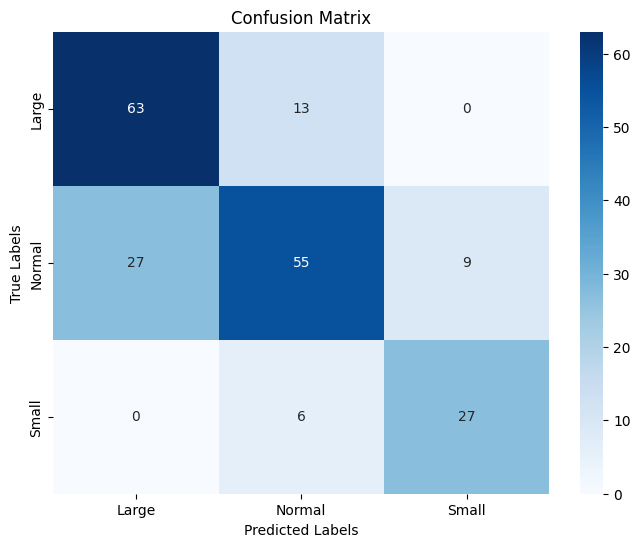

Classification Report:
              precision    recall  f1-score   support

       Large       0.70      0.83      0.76        76
      Normal       0.74      0.60      0.67        91
       Small       0.75      0.82      0.78        33

    accuracy                           0.72       200
   macro avg       0.73      0.75      0.74       200
weighted avg       0.73      0.72      0.72       200



In [ ]:
# Define class mapping
class_mapping = {'Large': 0, 'Normal': 1, 'Small': 2}

# Evaluate on validation set
evaluate_model(model, valid_loader, class_mapping)

Visualize training

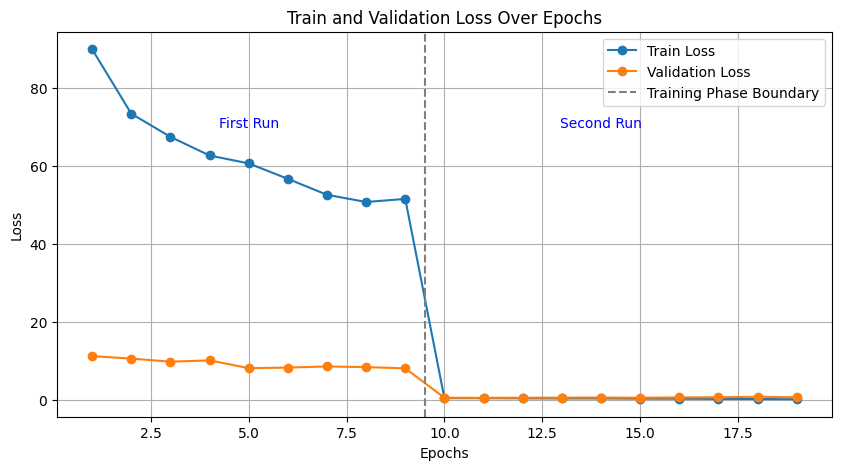

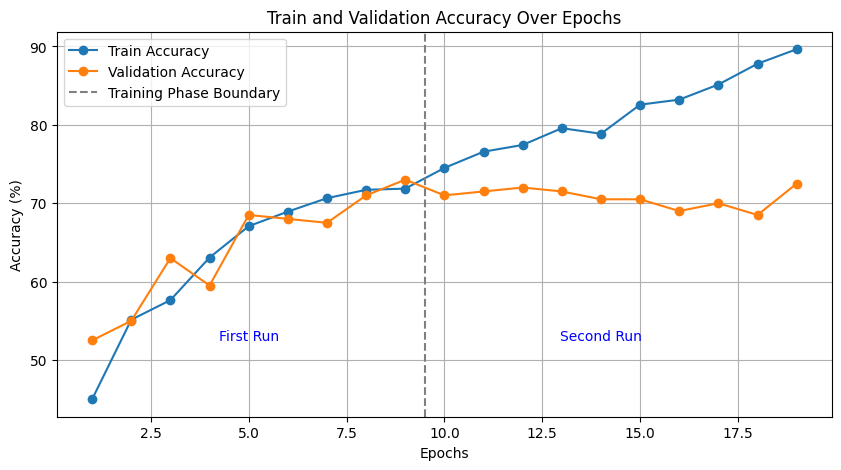

In [ ]:
import matplotlib.pyplot as plt

# Data from the first training run (9 epochs)
train_loss1 = [89.7928, 73.3045, 67.3772, 62.6062, 60.5824, 56.6348, 52.5526, 50.7125, 51.5024]
valid_loss1 = [11.2787, 10.6564, 9.8583, 10.1975, 8.1984, 8.3544, 8.6344, 8.4665, 8.1613]
train_accuracy1 = [45.00, 55.14, 57.64, 63.07, 67.07, 68.93, 70.64, 71.71, 71.86]
valid_accuracy1 = [52.50, 55.00, 63.00, 59.50, 68.50, 68.00, 67.50, 71.00, 73.00]

# Data from the second training run (10 epochs)
train_loss2 = [0.5310, 0.5186, 0.4893, 0.4541, 0.4627, 0.4060, 0.3952, 0.3352, 0.2984, 0.2577]
valid_loss2 = [0.6367, 0.6197, 0.6394, 0.6691, 0.6917, 0.6370, 0.7197, 0.7509, 0.8925, 0.7509]
train_accuracy2 = [74.50, 76.57, 77.43, 79.57, 78.86, 82.57, 83.21, 85.14, 87.79, 89.64]
valid_accuracy2 = [71.00, 71.50, 72.00, 71.50, 70.50, 70.50, 69.00, 70.00, 68.50, 72.50]

# Combine epochs and data from both runs for continuity
combined_epochs = list(range(1, 10 + 10))  # 9 epochs + 10 epochs (total 19 epochs)
combined_train_loss = train_loss1 + train_loss2
combined_valid_loss = valid_loss1 + valid_loss2
combined_train_accuracy = train_accuracy1 + train_accuracy2
combined_valid_accuracy = valid_accuracy1 + valid_accuracy2

# Plot Train Loss and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(combined_epochs, combined_train_loss, label="Train Loss", marker="o", linestyle="-")
plt.plot(combined_epochs, combined_valid_loss, label="Validation Loss", marker="o", linestyle="-")
plt.axvline(x=9.5, color='gray', linestyle="--", label="Training Phase Boundary")  # Indicator for boundary
plt.text(5, max(combined_train_loss)-20, "First Run", ha="center", color="blue", fontsize=10)
plt.text(14, max(combined_train_loss)-20, "Second Run", ha="center", color="blue", fontsize=10)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.savefig("train_validation_loss.png", dpi=300)  # Save the plot
plt.show()

# Plot Train Accuracy and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(combined_epochs, combined_train_accuracy, label="Train Accuracy", marker="o", linestyle="-")
plt.plot(combined_epochs, combined_valid_accuracy, label="Validation Accuracy", marker="o", linestyle="-")
plt.axvline(x=9.5, color='gray', linestyle="--", label="Training Phase Boundary")  # Indicator for boundary
plt.text(5, min(combined_valid_accuracy), "First Run", ha="center", color="blue", fontsize=10)
plt.text(14, min(combined_valid_accuracy), "Second Run", ha="center", color="blue", fontsize=10)
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train and Validation Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.savefig("train_validation_accuracy.png", dpi=300)  # Save the plot
plt.show()


##**Save Model to Drive if good:**

In [ ]:
# save model in google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
test_acc = '72%'

In [ ]:
import os
folder_path = '/content/drive/My Drive/'
if os.path.exists(folder_path):
    print("Folder exists:", folder_path)
else:
    print("Folder does not exist")

Folder does not exist


In [ ]:
import shutil

source_path = '/content/76%_best_model.pth'
destination_path = f'/content/drive/My Drive/YU Katz AI/Fall 24/Deep Learning/Project 1/76%_best_model.pth' # Change 'My Drive' to your desired folder

shutil.copyfile(source_path, destination_path)

'/content/drive/My Drive/YU Katz AI/Fall 24/Deep Learning/Project 1/76%_best_model.pth'

# 3. Evaluate your model using the developed software

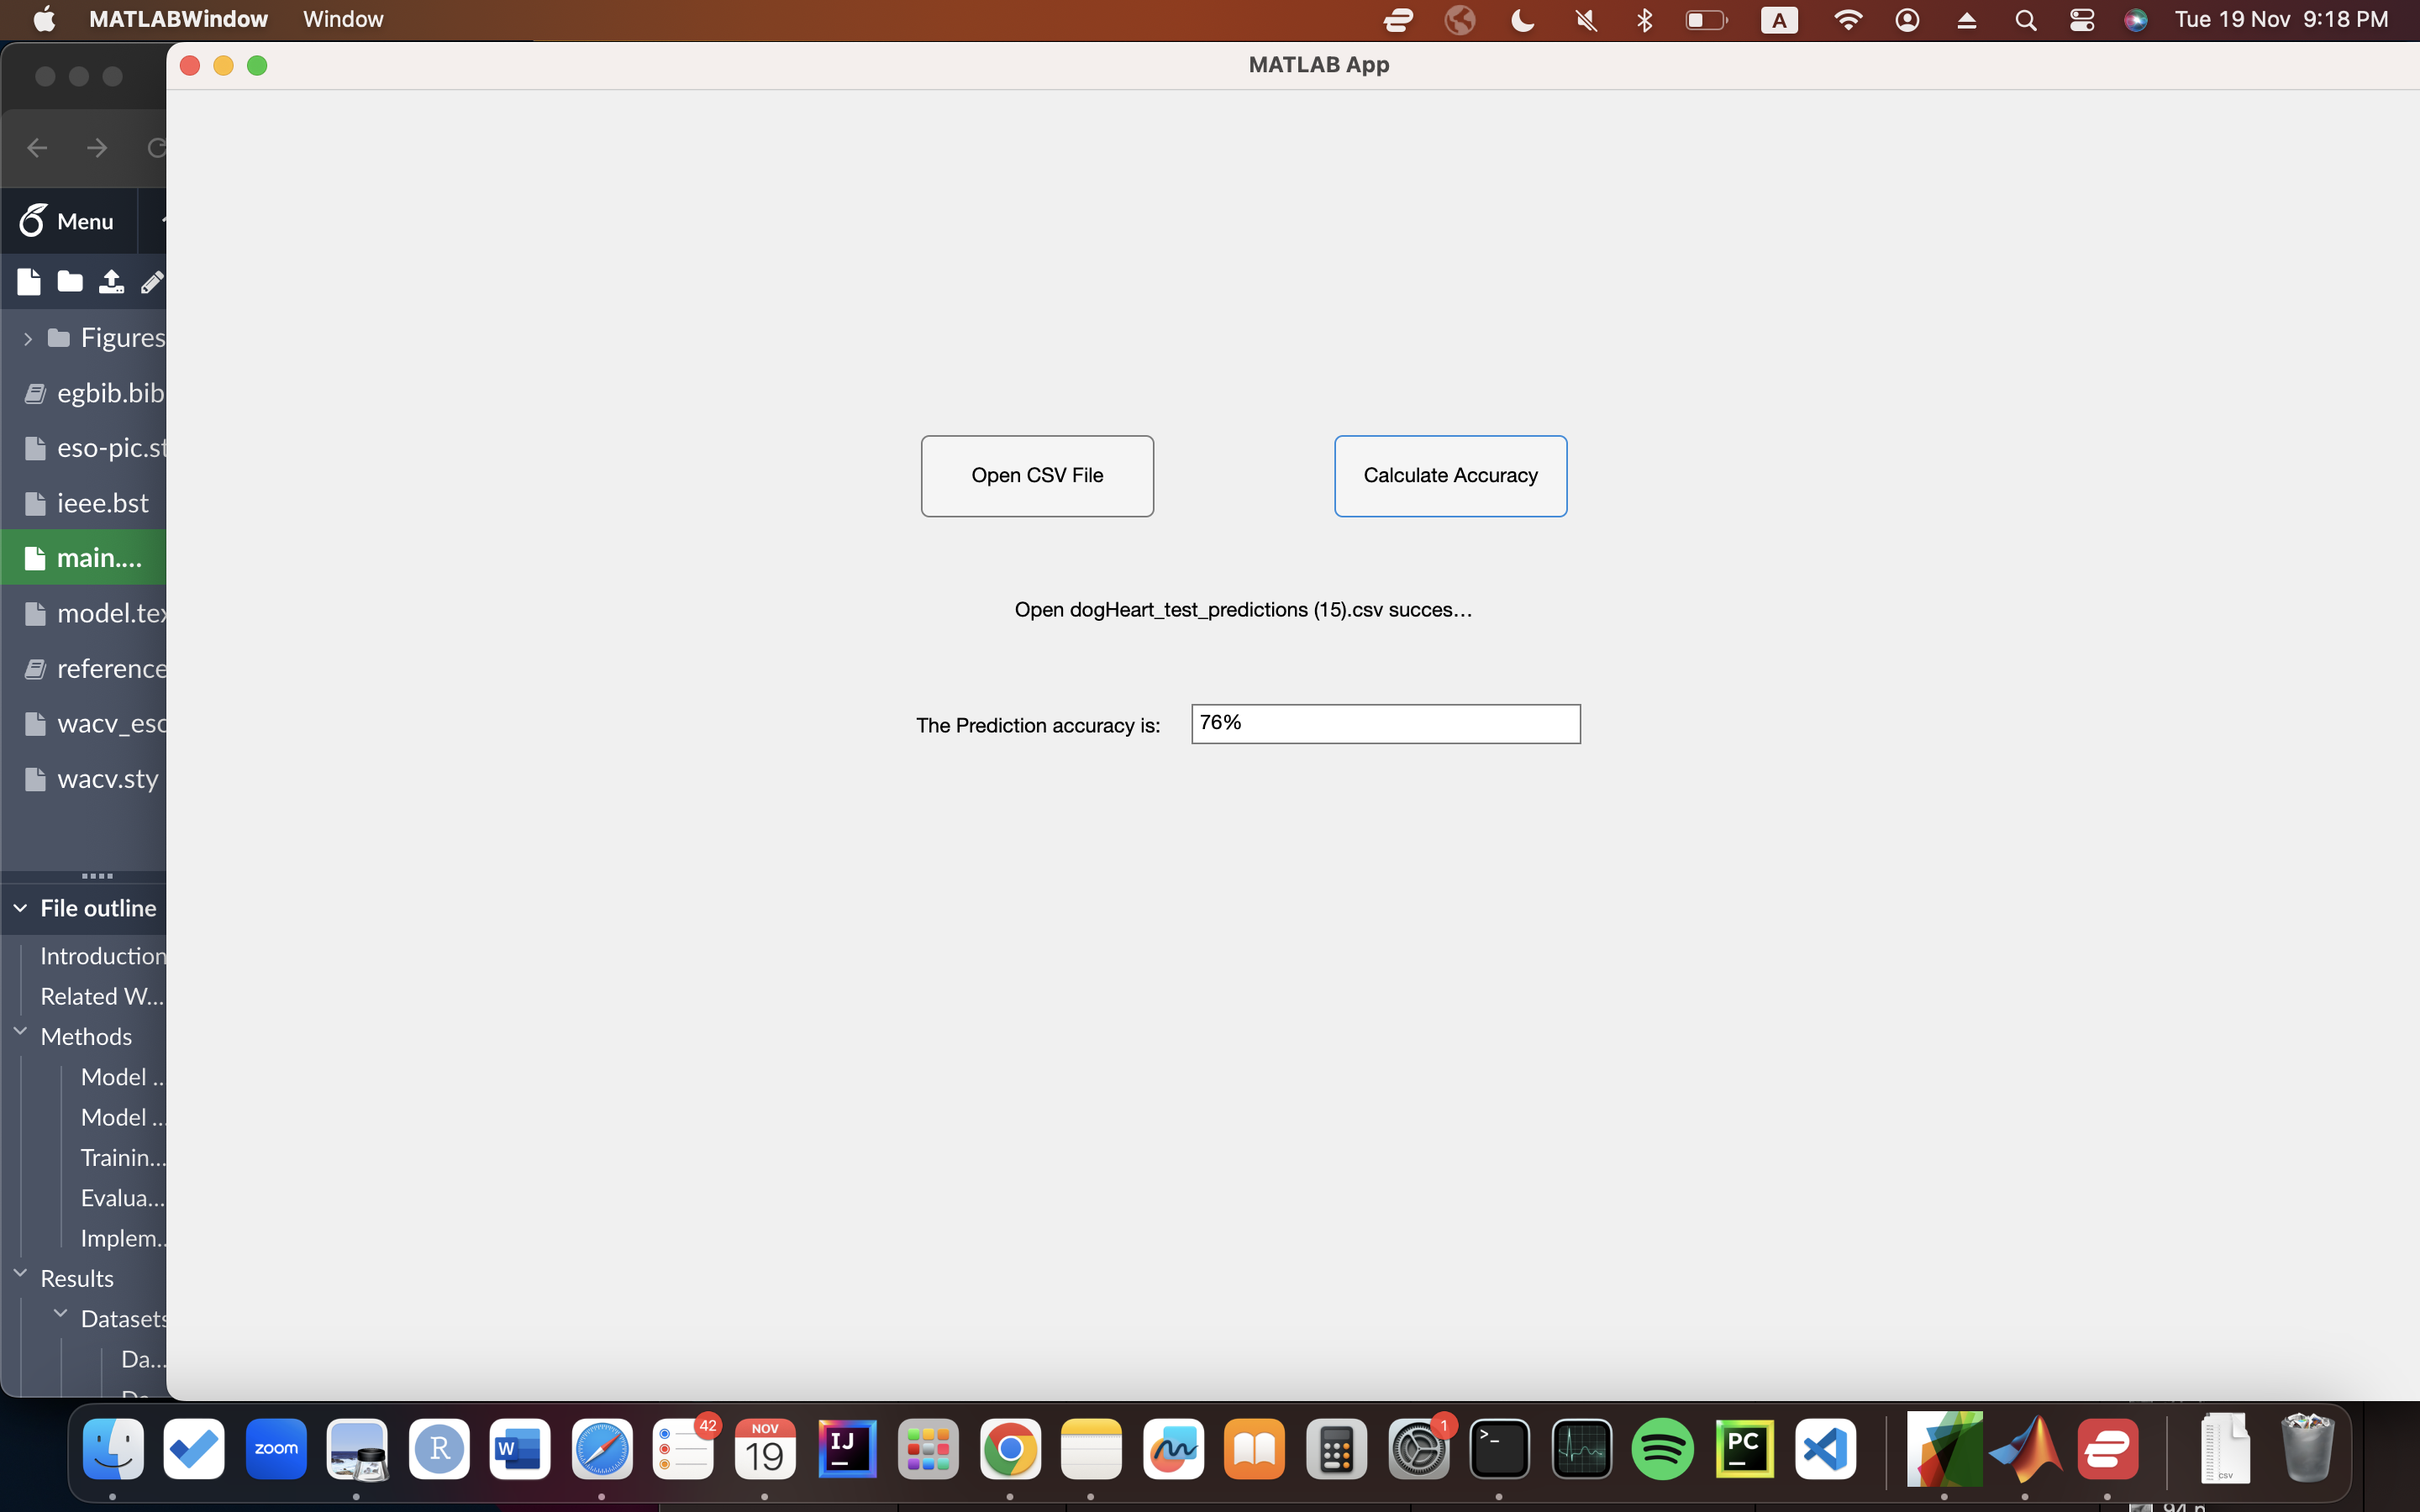

In [ ]:
from IPython.display import Image
Image('/content/76%_software_performance.png')

# 4. Compare results with [RVT paper](https://www.nature.com/articles/s41598-023-50063-x). Requirement: performance is better than VGG16: 75%

My CNN model achieved a test accuracy of 76%, while the RVT model reported a significantly higher test accuracy of 87.3%

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link and GitHub weight link here.

ResearchGate link:
https://www.researchgate.net/publication/385980912_Dog_Cardiomegaly_Classification

My ResearchGate profile:
https://www.researchgate.net/profile/Aaron-Meoded/research

Google drive link to the final model:
https://drive.google.com/file/d/1thd_I23fK73uSS61iOmZrRdgDuniiwJr/view?usp=sharing

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points


(4). Method  ---- 20 points

(5). Results ---- 20 points

     > = 75 % -->10 points
     < 55 % -->0 points
     >= 55 % & < 75% --> 0.5 point/percent
     

(6). Discussion - 10 points